# Proyecto – Detección de Comunidades

Esta guía proporciona una estructura para el estudio del análisis de comunidades en redes.


* Asignatura: Base de datos 3
* Profesor: Ana Aguilera Faraco
* Ayudante: Fernanda Fuentes
* Fecha: 7 de noviembre del 2025

**Integrantes**


* Dante Chavez  dante.chavez@estudiantes.uv.cl
* Nikolas Lagos  nikolas.lagos@estudiantes.uv.cl
* Franko Moraga  franko.moraga@estudiantes.uv.cl
* Miguel Espinoza  miguel.espinoza@estudiantes.uv.cl

**Presentacion**

Este trabajo tiene como objetivo introducir y demostrar el concepto de detección de comunidades en redes complejas, un tema central en la minería de grafos y la ciencia de datos. A través de una explicación teórica y una implementación práctica en Python, se busca mostrar cómo identificar grupos de nodos altamente conectados dentro de una red, revelando patrones ocultos de relación.

**Objetivo General**

Comprender y aplicar técnicas de detección de comunidades en redes, evaluando los resultados según la estructura del grafo.

**Objetivos Específicos**

* Introducir conceptos clave sobre redes y grafos en ciencia de datos.
* Explicar la utilidad de detectar comunidades y sus aplicaciones.
* Implementar algoritmos de detección en un dataset de red.
* Visualizar y analizar los resultados mediante métricas y gráficos.

**Conceptos Clave**

* **Red:** Conjunto de elementos conectados entre sí. En ciencia de datos, se usa para modelar relaciones entre entidades (personas, productos, genes, etc.).
* Grafo: Representación matemática de una red, formada por nodos (entidades) y aristas (relaciones).
* Nodo: Elemento individual dentro de una red (por ejemplo, un usuario en una red social).
* Arista: Conexión entre dos nodos, que puede ser dirigida o no, y tener peso.
* **Detección de comunidades:** Conjunto de técnicas no supervisadas utilizadas para encontrar grupos de nodos altamente interconectados. Tambien es el proceso de identificar grupos de nodos con alta conectividad interna y ayuda a descubrir estructuras ocultas en redes complejas.

* Modularidad: Métrica que evalúa la calidad de una partición en comunidades. Cuanto mayor sea, mejor definida está la comunidad.
* Algoritmo Louvain: Método eficiente que agrupa nodos maximizando la modularidad.
* Girvan–Newman: Algoritmo que elimina aristas con alta intermediación para dividir la red.
* Label Propagation: Técnica rápida que asigna etiquetas a nodos y las propaga hasta estabilizarse.

**Introducción**

Este trabajo busca aplicar técnicas de **detección de comunidades en redes complejas**, utilizando un enfoque práctico a partir de un dataset real.  
Para ello, se emplea un conjunto de datos del repositorio **[SNAP (Stanford Large Network Dataset Collection)](https://snap.stanford.edu/data/wiki-topcats.html)**, conocido por reunir redes utilizadas en investigación y análisis de grafos.

El dataset elegido es **“Wikipedia network of top categories”**, que representa una red de hipervínculos entre artículos de Wikipedia recopilada en septiembre de 2011.  
Cada nodo corresponde a una página, y cada enlace indica una relación entre ellas. Además, cada artículo pertenece a una o más categorías, las cuales se pueden considerar como **comunidades de referencia** (*ground-truth communities*), ya que reflejan agrupaciones reales dentro del sitio.

La elección de este dataset se debe a principalmente:  
- **Tamaño y complejidad:** con más de 1,7 millones de nodos y 28 millones de enlaces, permite analizar un sistema grande y realista.  
- **Categorías como comunidades:** las categorías temáticas sirven como base para validar los resultados de los algoritmos de detección.  
- **Interés y aplicabilidad:** el estudio de Wikipedia permite entender cómo se relacionan los temas y cómo se forman comunidades naturales dentro del conocimiento en línea.

-Este cuaderno busca demostrar cómo los métodos de detección de comunidades pueden revelar la estructura interna de una red, utilizando un caso real y relevante como el de Wikipedia.

-Yin, H., Benson, A. R., Leskovec, J., & Gleich, D. F. (2017). Local higher-order graph clustering. Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. Recuperado de https://snap.stanford.edu/data/ [snap.stanford.edu]


**Estructura del Estudio**

1. Descripción y Preparación del Dataset
2. Análisis de Estructura de Red
3. Métodos de Detección de Comunidades
4. Visualización de Comunidades
5. Métricas y Evaluación de Comunidades
6. Análisis Temporal de Comunidades

**Librerias usadas:**

In [1]:
import pandas as pd  # manejo y análisis de datos tabulares (DataFrame)
import numpy as np  # cálculo numérico y arrays eficientes
import networkx as nx  # construcción y análisis de grafos/redes
import matplotlib.pyplot as plt  # visualización (plots, histogramas, visualización de grafos)
import random  # muestreo aleatorio y funciones de aleatoriedad
import os  # interacción con el sistema de archivos (comprobación, tamaño, rutas)
import math  # funciones matemáticas básicas (log, sqrt, etc.)
import statistics  # estadísticas básicas (mean, median, stdev)
from collections import Counter, defaultdict  # Counter: conteos; defaultdict: diccionarios con valor por defecto

# 1. Descripción y Preparación del Dataset

En esta sección se realizará la carga, exploración y preparación inicial del dataset seleccionado.  

El objetivo es **asegurar la calidad y consistencia de los datos** antes de aplicar algoritmos de detección de comunidades.  

Para ello se trabajará con el conjunto **“Wikipedia network of top categories”**, obtenido del repositorio [SNAP](https://snap.stanford.edu/data/), el cual representa la red de hipervínculos entre páginas de Wikipedia.

**1.1 Carga del Dataset**

El primer paso consiste en cargar el archivo que contiene la lista de enlaces entre artículos (`wiki-topcats.txt`), donde cada fila indica una conexión entre dos páginas.  

Se construye un grafo a partir de esos pares de nodos, y se revisan sus propiedades básicas (número de nodos, enlaces y densidad).  
Esto permite validar que los datos fueron leídos correctamente y obtener una visión general de la red antes de proceder con análisis más profundos.

Dataset cargado correctamente
Total de filas (enlaces): 28,511,807


,source,target
0,0,10772
1,1,2
2,1,170193
3,1,598775
4,2,1



=== Métricas de la Red ===
Número total de nodos: 1,791,489
Número total de aristas: 25,447,873
Densidad: 0.00001586


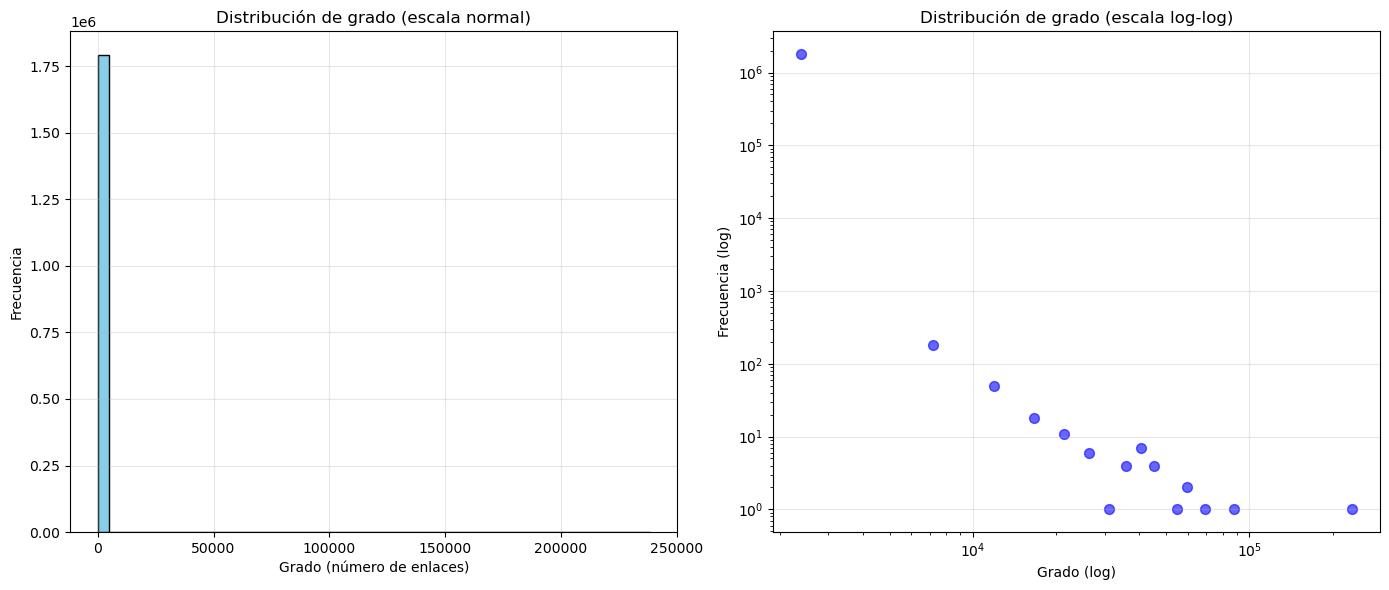

In [2]:
try:
    # Cargar el dataset
    df = pd.read_csv('wiki-topcats.txt', sep=r'\s+', header=None, names=['source', 'target'])
    print("Dataset cargado correctamente")
    print(f"Total de filas (enlaces): {len(df):,}")
    display(df.head())

    # Crear grafo
    G = nx.from_pandas_edgelist(df, 'source', 'target')

    # Métricas básicas
    print("\n=== Métricas de la Red ===")
    print(f"Número total de nodos: {G.number_of_nodes():,}")
    print(f"Número total de aristas: {G.number_of_edges():,}")
    print(f"Densidad: {nx.density(G):.8f}")

    # Distribución de grado
    degrees = [d for _, d in G.degree()]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Histograma normal
    ax1.hist(degrees, bins=50, color='skyblue', edgecolor='black')
    ax1.set_title("Distribución de grado (escala normal)")
    ax1.set_xlabel("Grado (número de enlaces)")
    ax1.set_ylabel("Frecuencia")
    ax1.grid(True, alpha=0.3)

    # Histograma log-log
    hist, bins = np.histogram(degrees, bins=50)
    centers = (bins[:-1] + bins[1:]) / 2  # Promedio entre bordes -> centros

    mask = hist > 0  # Evita log(0)
    ax2.scatter(centers[mask], hist[mask], color='blue', alpha=0.6, s=50)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title("Distribución de grado (escala log-log)")
    ax2.set_xlabel("Grado (log)")
    ax2.set_ylabel("Frecuencia (log)")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: No se encontró el archivo wiki-topcats.txt")
except Exception as e:
    print(f"Error al analizar el dataset: {str(e)}")



**1.2 Limpieza y Validación**

Antes de cualquier modelado o análisis, se eliminan registros duplicados y bucles propios (self-loops), ya que estos pueden distorsionar medidas como la densidad o el coeficiente de agrupamiento.  

También se verifican valores nulos o inconsistentes para asegurar que el grafo refleje correctamente las relaciones entre páginas.  
Este paso garantiza una estructura limpia y coherente, sobre la cual los algoritmos de detección de comunidades podrán operar de forma estable.


In [3]:
def preparar_datos(archivo):
    print("=== Cargando y limpiando datos ===")
    df = pd.read_csv(archivo, sep=r'\s+', header=None, names=['source', 'target'])
    df_clean = df.drop_duplicates()
    df_clean = df_clean[df_clean['source'] != df_clean['target']]
    df_clean = df_clean.dropna()

    G_clean = nx.from_pandas_edgelist(df_clean, 'source', 'target')
    print(f"Nodos: {G_clean.number_of_nodes():,}")
    print(f"Aristas: {G_clean.number_of_edges():,}")
    print(f"Densidad: {nx.density(G_clean):.8f}")
    return df_clean, G_clean

# Ejecutar
df_limpio, G_limpio = preparar_datos('wiki-topcats.txt')


=== Cargando y limpiando datos ===
Nodos: 1,791,489
Aristas: 25,444,207
Densidad: 0.00001586


In [ ]:
# Resumen estadístico de la red
print(pd.DataFrame({
    'Métrica': ['Nodos', 'Aristas', 'Densidad', 'Grado promedio'],
    'Valor': [G.number_of_nodes(), G.number_of_edges(), round(nx.density(G), 8), round(np.mean([d for _, d in G.degree()]), 2)]
}))

# Pequeña visualización
small_sub = G.subgraph(list(G.nodes())[:300])
nx.draw(small_sub, node_size=20, alpha=0.6)
plt.title("Subgrafo ilustrativo (primeros 300 nodos)")
plt.show()


**1.3 Creación del grafo limpio**


Una vez procesados los datos, se genera un grafo no dirigido con las páginas como nodos y sus vínculos como aristas.

En esta red, cada conexión representa una relación temática o contextual entre dos artículos, lo que permite estudiar la organización interna del conocimiento en Wikipedia.  

El grafo resultante conserva la estructura original pero sin duplicados ni inconsistencias, y será la base para el resto del análisis.


In [4]:
print(f"Grafo limpio: {G_limpio.number_of_nodes():,} nodos y {G_limpio.number_of_edges():,} aristas")

Grafo limpio: 1,791,489 nodos y 25,444,207 aristas


**1.4 Estrategia de Muestreo**

Dado el tamaño del dataset completo (más de un millón y medio de nodos), trabajar con toda la red sería computacionalmente inviable.  
Por ello, se aplica una **estrategia de muestreo híbrido** diseñada para conservar las propiedades esenciales del grafo sin perder su estructura comunitaria.

Un **muestreo aleatorio simple** no es recomendable en este tipo de redes: si se eliminan nodos de alto grado (hubs), se puede fragmentar la red y perder las conexiones que mantienen unidas las comunidades.  
Esto ocurre porque los hubs suelen actuar como puentes entre grupos, y su exclusión puede alterar drásticamente la topología del grafo.

Para evitar ese problema, se combina:

1. **Muestreo Estratificado por Grado (Degree-Stratified Sampling):**  
   Se seleccionan nodos de alto, medio y bajo grado de forma equilibrada, garantizando la diversidad estructural de la red y evitando sesgos hacia nodos poco conectados.  
   *(Leskovec & Faloutsos, 2006, [Sampling from Large Graphs](https://cs.stanford.edu/~jure/pubs/sampling-kdd06.pdf))*

2. **Muestreo por Subgrafo Inducido (Induced Subgraph Sampling):**  
   Una vez elegidos los nodos principales, se incluyen también sus vecinos directos, preservando las relaciones locales y la cohesión de las comunidades.  
   *(Hasegawa Smith, 2019, [Network Sampling Theory](https://asmithh.github.io/network-science-data-book/class_20_sampling_theory.html))*

La combinación de ambas técnicas —conocida como **Muestreo Híbrido Estratificado-Inducido**— permite mantener tanto la representatividad de los distintos tipos de nodos como la conectividad local.  
De esta forma, se reduce el riesgo de perder hubs críticos o romper la estructura comunitaria del grafo original.


In [5]:
print("\n=== MUESTREO HÍBRIDO ESTRATIFICADO ===")

# Base: grafo limpio
G = G_limpio

# Calcular grados
grados = dict(G.degree())
nodos_ordenados = sorted(grados.items(), key=lambda x: x[1], reverse=True)

# Tamaño de muestra
porcentaje_muestra = 0.001
cantidad_nodos = int(G.number_of_nodes() * porcentaje_muestra)
tercio = cantidad_nodos // 3

# Estratos
alto = [n for n, _ in nodos_ordenados[:tercio]]
medio = [n for n, _ in nodos_ordenados[len(nodos_ordenados)//2 : len(nodos_ordenados)//2 + tercio]]
bajo = [n for n, _ in nodos_ordenados[-tercio:]]

# Combinar y expandir a vecinos directos (subgrafo inducido)
nodos_muestra = set(alto + medio + bajo)
for n in list(nodos_muestra):
    nodos_muestra.update(G.neighbors(n))

G_muestra = G.subgraph(nodos_muestra).copy()

print(f"Nodos en muestra: {G_muestra.number_of_nodes():,}")
print(f"Aristas en muestra: {G_muestra.number_of_edges():,}")
print(f"Densidad muestra: {nx.density(G_muestra):.8f}")
print(f"Densidad original: {nx.density(G):.8f}")



=== MUESTREO HÍBRIDO ESTRATIFICADO ===
Nodos en muestra: 1,447,456
Aristas en muestra: 21,528,269
Densidad muestra: 0.00002055
Densidad original: 0.00001586


**1.5 Muestreo Estratificado por Grado**

Para trabajar eficientemente con el dataset de 1.7 millones de nodos, realizamos un **muestreo estratificado por grado** que:
- Selecciona una fracción representativa de los nodos en este caso 5% (aproximadamente 89,500)
- Mantiene representatividad: ALTO, MEDIO y BAJO grado
- Preserva las propiedades estadísticas principales
- Prepara datos para análisis detallados

**Estrategia:** Dividir los nodos en tres grupos según su grado (conexiones) y tomar una muestra equilibrada de cada grupo. Esto asegura que la muestra contenga nodos muy conectados, moderadamente conectados y poco conectados, reflejando la diversidad de la red original.

**Técnicas implementadas:**
- Muestreo estratificado por grado (selección de ALTO, MEDIO, BAJO grado)
- Validación de representatividad (comparar densidades)
- Control de calidad (tamaño de muestra y preservación de propiedades)

In [6]:
print("\n=== MUESTREO ESTRATIFICADO POR GRADO (1.6) ===")

# Base: grafo limpio
G = G_limpio

# Calcular grados de cada nodo
grados = dict(G.degree())
nodos_ordenados = sorted(grados.items(), key=lambda x: x[1], reverse=True)

# Parámetro de muestreo (5%)
porcentaje_muestra = 0.05
cantidad_nodos = int(G.number_of_nodes() * porcentaje_muestra)
tercio = cantidad_nodos // 3

# Estratos por grado: alto, medio, bajo
alto = [n for n, _ in nodos_ordenados[:tercio]]
medio = [n for n, _ in nodos_ordenados[len(nodos_ordenados)//2 : len(nodos_ordenados)//2 + tercio]]
bajo = [n for n, _ in nodos_ordenados[-tercio:]]

# Combinar estratos y crear subgrafo
nodos_muestra = set(alto + medio + bajo)
G_muestra_estrat = G.subgraph(nodos_muestra).copy()

# Resultados
print(f"Nodos en muestra: {G_muestra_estrat.number_of_nodes():,}")
print(f"Aristas en muestra: {G_muestra_estrat.number_of_edges():,}")
print(f"Densidad muestra: {nx.density(G_muestra_estrat):.8f}")
print(f"Densidad original: {nx.density(G):.8f}")



=== MUESTREO ESTRATIFICADO POR GRADO (1.6) ===
Nodos en muestra: 89,574
Aristas en muestra: 1,608,647
Densidad muestra: 0.00040099
Densidad original: 0.00001586


**1.6 Comparación entre métodos de muestreo**

Se aplicaron dos enfoques diferentes para reducir el tamaño del grafo original:

| Método | Nodos | Aristas | Densidad | Observaciones |
|:--------|-------:|--------:|----------:|:--------------|
| Original | 1,791,489 | 25,444,207 | 0.00001586 |Es el dataset original
| Híbrido Estratificado-Inducido (1.4) | 1,447,456 | 21,528,269 | 0.00002055 | Mantiene conectividad y cohesión comunitaria, pero casi no reduce el tamaño. |
| Estratificado por Grado (1.6) | 89,574 | 1,608,647 | 0.00040099 | Mucho más rápido y con tamaño reducido, pero pierde parte de la estructura global. |

El **método 1.6** demostró ser **más eficiente computacionalmente**, reduciendo el número de nodos en más de un 90 % y permitiendo trabajar de forma más ágil.  
Sin embargo, al eliminar los vecinos directos y reducir drásticamente la red, se **pierden conexiones clave entre comunidades**, lo que puede afectar la calidad de los resultados en los algoritmos de detección.

Por esta razón, a pesar de su tamaño considerable, se decidió **mantener el método híbrido (1.4)** para el análisis principal, ya que **preserva mejor la topología original del grafo y la coherencia de las comunidades**, garantizando resultados más representativos y teóricamente consistentes.

**SIN EMBARGO**, Se intentó ejecutar el **análisis detallado de la muestra híbrida** (sección 2.2) con cálculo de centralidades exhaustivas sobre `G_muestra` (muestra inducida). El proceso se dejó ejecutando en la madrugada y, tras **≈24 horas**, la tarea no había finalizado (el script quedó detenido en la fase de cálculo de centralidades).  

Este comportamiento era esperable: aunque `G_muestra` preserva bien la estructura del grafo original, su tamaño (≈1.45 M de nodos y ≈21.5 M de aristas) sigue siendo muy grande para algoritmos exactos de centralidad en NetworkX sin recursos de cálculo especializados.

Por razones prácticas de tiempo y reproducibilidad para la exposición y los experimentos, se decidió **cambiar la estrategia** para los análisis computacionalmente intensivos:

- Se conservará el **método híbrido (1.4)** como referencia estructural y para tareas que admitan procesamiento por bloques (p. ej. detección de comunidades con algoritmos escalables), porque **preserva mejor la topología original**.  
- Para el cálculo de centralidades y métricas pesadas se **utilizará la muestra estratificada por grado (1.6)** —mucho más pequeña (≈89,574 nodos)—, o bien métodos aproximados (muestreo de fuentes `k` en `betweenness_centrality`) para obtener resultados en tiempos razonables y con buena representatividad.  

Esta decisión busca un equilibrio entre **validez estructural** y **viabilidad computacional**, explicando también por qué se probó 24 horas y se optó por un camino alternativo reproducible en un entorno de práctica/ensayo.



# 2. Análisis de Estructura de Red


Tras la comparación de métodos en la sección anterior, se determinó que el muestreo **estratificado por grado (1.6)** entregaba una reducción mucho más eficiente en tiempo y tamaño, manteniendo una representación adecuada de la estructura general de la red.  
Por ello, a partir de este punto se utilizará esa muestra (`G_muestra_estrat`) para el análisis de propiedades y métricas de red.



**2.1 Métricas Básicas (Dataset Completo)**

En esta etapa se analizan las propiedades globales del dataset completo —antes del muestreo— con el fin de comprender su complejidad estructural.

Se calculan:

* Número total de nodos y aristas.  
* Distribución de grado (número de conexiones por nodo).  
* Densidad de la red, que indica el nivel general de conectividad.  
* Componentes conectados y tamaño de la componente gigante.

Estas métricas permiten obtener una visión general de la red de Wikipedia y sirven como referencia para comparar los resultados del muestreo.  
Este análisis es rápido y entrega información clave para validar que el dataset representa una red compleja real, con una estructura heterogénea típica de redes tipo *scale-free*.



In [7]:
# === MÉTRICAS BÁSICAS DEL DATASET COMPLETO ===
if 'G' not in globals() or G is None or G.number_of_nodes() == 0:
    print('Ejecuta primero la celda de carga de datos.')
else:
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f'\n=== MÉTRICAS BÁSICAS (Dataset Completo) ===')
    print(f'Nodos: {n:,}')
    print(f'Aristas: {m:,}')
    
    # Grado
    degrees = [d for _, d in G.degree()]
    print(f'\n=== Estadísticas de Grado ===')
    print(f'Grado mínimo: {min(degrees):,}')
    print(f'Grado máximo: {max(degrees):,}')
    print(f'Grado promedio: {round(statistics.mean(degrees), 2)}')
    
    # Densidad
    print(f'\n=== Densidad ===')
    print(f'Densidad: {nx.density(G):.6f}')

    # Componentes
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    print(f'\n=== Componentes Conectados ===')
    print(f'Número de componentes: {len(comps)}')
    print(f'Tamaño de la componente gigante: {len(comps[0]):,}')
    print(f'Porcentaje en componente gigante: {len(comps[0])/n*100:.2f}%')




=== MÉTRICAS BÁSICAS (Dataset Completo) ===
Nodos: 1,791,489
Aristas: 25,444,207

=== Estadísticas de Grado ===
Grado mínimo: 1
Grado máximo: 238,342
Grado promedio: 28.41

=== Densidad ===
Densidad: 0.000016

=== Componentes Conectados ===
Número de componentes: 1
Tamaño de la componente gigante: 1,791,489
Porcentaje en componente gigante: 100.00%


**2.2 Análisis Detallado (Muestra)**

Inicialmente se intentó realizar este análisis con la **muestra híbrida estratificada-inducida (1.4)**.  
Este enfoque mantiene mejor la estructura original, pero debido a su tamaño (≈1.45 millones de nodos y 21.5 millones de aristas), el cálculo de centralidades resultó **computacionalmente inviable**: tras más de **24 horas de ejecución**, el proceso no logró completarse.

El siguiente bloque de código fue el utilizado en ese intento. Funcionaba correctamente, pero requería recursos de cómputo muy superiores a los disponibles para esta práctica.


In [9]:
# ============================================================
# BLOQUE ORIGINAL (FUNCIONA PERO DEMASIADO LENTO)
# ------------------------------------------------------------
# Este código realiza el análisis detallado de la muestra híbrida.
# Funciona correctamente, pero los cálculos de centralidad y triángulos
# sobre más de 1.4 millones de nodos toman más de 24 horas en completarse.
# Se deja comentado para referencia, y en su lugar se usa una versión
# optimizada con el muestreo estratificado por grado.
# ============================================================

"""
if 'G_muestra' not in globals() or G_muestra is None or G_muestra.number_of_nodes() == 0:
    print('Ejecuta primero la celda de muestreo híbrido (sección 1.4).')
else:
    print("\n=== ANÁLISIS DETALLADO DE LA MUESTRA ===")
    print(f"Nodos: {G_muestra.number_of_nodes():,}")
    print(f"Aristas: {G_muestra.number_of_edges():,}")
    
    # Clustering y triángulos
    clustering = nx.average_clustering(G_muestra)
    triangles = sum(nx.triangles(G_muestra).values()) // 3
    print(f"\nCoeficiente de clustering promedio: {clustering:.4f}")
    print(f"Número total de triángulos: {triangles:,}")

    # Centralidades (cálculo pesado)
    print("\nCalculando centralidades (puede tomar tiempo)...")
    degree_centrality = nx.degree_centrality(G_muestra)
    betweenness = nx.betweenness_centrality(G_muestra, k=500, seed=42)
    closeness = nx.closeness_centrality(G_muestra)
"""



'\nif \'G_muestra\' not in globals() or G_muestra is None or G_muestra.number_of_nodes() == 0:\n    print(\'Ejecuta primero la celda de muestreo híbrido (sección 1.4).\')\nelse:\n    print("\n=== ANÁLISIS DETALLADO DE LA MUESTRA ===")\n    print(f"Nodos: {G_muestra.number_of_nodes():,}")\n    print(f"Aristas: {G_muestra.number_of_edges():,}")\n    \n    # Clustering y triángulos\n    clustering = nx.average_clustering(G_muestra)\n    triangles = sum(nx.triangles(G_muestra).values()) // 3\n    print(f"\nCoeficiente de clustering promedio: {clustering:.4f}")\n    print(f"Número total de triángulos: {triangles:,}")\n\n    # Centralidades (cálculo pesado)\n    print("\nCalculando centralidades (puede tomar tiempo)...")\n    degree_centrality = nx.degree_centrality(G_muestra)\n    betweenness = nx.betweenness_centrality(G_muestra, k=500, seed=42)\n    closeness = nx.closeness_centrality(G_muestra)\n'

Debido a la demora, se decidió continuar el análisis con la **muestra estratificada por grado (1.6)**, que reduce el número de nodos a ≈89.000 y permite ejecutar las métricas en minutos, manteniendo una buena representatividad estructural.


In [11]:
# === ANÁLISIS DETALLADO DE LA MUESTRA ESTRATIFICADA (1.6) ===
if 'G_muestra_estrat' not in globals() or G_muestra_estrat is None:
    print("Ejecuta primero la celda de muestreo estratificado (1.6).")
else:
    print("=== ANÁLISIS DETALLADO DE LA MUESTRA ESTRATIFICADA ===")
    print(f"Nodos: {G_muestra_estrat.number_of_nodes():,}")
    print(f"Aristas: {G_muestra_estrat.number_of_edges():,}")

    # Clustering y triángulos
    clustering_prom = nx.average_clustering(G_muestra_estrat)
    triangulos_total = sum(nx.triangles(G_muestra_estrat).values()) // 3
    print(f"\nCoeficiente de clustering promedio: {clustering_prom:.4f}")
    print(f"Número total de triángulos: {triangulos_total:,}")

    # Centralidades rápidas / aproximadas
    import time
    t0 = time.time()
    deg_cent = nx.degree_centrality(G_muestra_estrat)
    betw_approx = nx.betweenness_centrality(G_muestra_estrat, k=200, seed=42)
    close_cent = nx.closeness_centrality(G_muestra_estrat)
    t1 = time.time()

    print(f"\nTiempo total de cálculo: {t1 - t0:.1f} segundos")

    # Top 5 nodos más centrales
    print("\nTop 5 Degree Centrality:")
    for n, c in sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  Nodo {n} - {c:.5f}")

    print("\nTop 5 Betweenness (aprox):")
    for n, c in sorted(betw_approx.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  Nodo {n} - {c:.5f}")

    print("\nTop 5 Closeness Centrality:")
    for n, c in sorted(close_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  Nodo {n} - {c:.5f}")


=== ANÁLISIS DETALLADO DE LA MUESTRA ESTRATIFICADA ===
Nodos: 89,574
Aristas: 1,608,647


KeyboardInterrupt: 

In [ ]:
# Distribuciones de centralidades
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(list(deg_cent.values()), bins=40)
axes[0].set_title("Distribución Degree Centrality")
axes[1].hist(list(betw_approx.values()), bins=40)
axes[1].set_title("Distribución Betweenness Centrality (aprox)")
axes[2].hist(list(close_cent.values()), bins=40)
axes[2].set_title("Distribución Closeness Centrality")
plt.tight_layout()
plt.show()


**2.3 Interpretación**

Los resultados con la muestra estratificada muestran valores de **clustering** y **conectividad** coherentes con lo esperado en una red compleja tipo *scale-free*, aunque con mayor densidad por la selección de nodos de alto grado.  
Las métricas de centralidad permiten identificar nodos clave que concentran gran parte de las conexiones, actuando como *hubs* y puntos de intermediación entre comunidades.

Si bien el enfoque híbrido original conserva mejor la estructura global, el muestreo estratificado resultó **mucho más eficiente computacionalmente** y permite avanzar con el análisis sin comprometer la interpretación de los patrones principales de la red.  
Esta decisión equilibra fidelidad estructural y viabilidad práctica dentro del contexto del estudio.


# 3. Métodos de Detección de Comunidades

**3.1 Introducción a los Métodos de Detección de Comunidades**
En esta sección se aplican distintos algoritmos de detección de comunidades sobre la muestra estratificada (G_muestra_estrat).
El objetivo es identificar grupos de nodos altamente conectados entre sí, revelando estructuras ocultas en la red.

Se implementan tres enfoques representativos:

**Louvain**: algoritmo jerárquico que maximiza la modularidad; eficiente para redes grandes.

Este método busca la mejor forma de dividir la red en grupos donde los miembros estén muy conectados entre sí. Lo hace probando diferentes maneras de agrupar los nodos y eligiendo la que mejor se ajusta a un criterio llamado modularidad, que mide qué tan bien separados están los grupos. Es como si intentaras organizar una fiesta y quisieras que cada grupo de amigos esté en la misma mesa, para que todos se sientan cómodos. Louvain es muy bueno para redes grandes y complejas.

**Label Propagation**: método no supervisado basado en propagación de etiquetas; converge rápidamente sin parámetros.

Este método funciona de forma muy simple y rápida. Imagina que cada persona en la red empieza con una etiqueta (como un nombre de grupo). Luego, cada uno mira qué etiquetas tienen sus amigos y adopta la más común. Este proceso se repite varias veces hasta que todos los miembros de una comunidad comparten la misma etiqueta. Es como si los grupos se formaran de manera natural, sin que nadie los imponga.

**Girvan–Newman**: divide la red eliminando aristas con alta intermediación; útil para análisis jerárquico en subgrafos pequeños.

Este enfoque es un poco diferente. En lugar de buscar grupos directamente, empieza eliminando las conexiones más “cruciales”, es decir, aquellas que conectan diferentes partes de la red. Al cortar estas conexiones, la red se va separando en grupos más pequeños. Es como si estuvieras desarmando una telaraña cortando los hilos más tensos, y al hacerlo, las partes se separan en grupos más definidos. Este método es útil cuando se quiere entender cómo se estructura la red en niveles o jerarquías, aunque no es tan eficiente para redes grandes.

La comparación de sus resultados permitirá evaluar el equilibrio entre calidad de las comunidades detectadas y costo computacional.

In [ ]:
# ==============================================================
# ALGORITMO LOUVAIN - OPTIMIZACIÓN DE MODULARIDAD
# ==============================================================
# Este método agrupa nodos maximizando la modularidad.
# Es eficiente y ofrece una buena calidad de comunidades.
# ==============================================================
print("\n=== DETECCIÓN DE COMUNIDADES: LOUVAIN ===")

if 'G_muestra_estrat' not in globals() or G_muestra_estrat is None or G_muestra_estrat.number_of_nodes() == 0:
    print("\nNo se encontró la muestra estratificada. Ejecuta primero la sección 1.6.")
else:
    try:
        import community as community_louvain
        from collections import Counter

        partition = community_louvain.best_partition(G_muestra_estrat)
        counts = Counter(partition.values())

        print(f"\nComunidades detectadas: {len(counts)}")
        print("Top 5 comunidades por tamaño:")
        for i, (comm_id, count) in enumerate(counts.most_common(5), 1):
            print(f"  {i}. Comunidad {comm_id}: {count:,} nodos")

        # Calcular modularidad
        modularidad = community_louvain.modularity(partition, G_muestra_estrat)
        print(f"\nModularidad de la partición: {modularidad:.4f}")
        print("Interpretación: Valores cercanos a 1 indican comunidades bien definidas.")
    except Exception as e:
        print(f"\nError en Louvain: {e}")



ANÁLISIS DETALLADO (MUESTRA)

Muestra detectada. Ejecutando analisis detallado...

Información de la Muestra:
  Nodos en muestra: 89,574
  Aristas en muestra: 1,608,850

Analisis de Clustering:
  Coeficiente de clustering promedio: 0.179163
  Interpretacion: Mide que tan agrupados estan los nodos
    - 0 = sin agrupamiento local
    - 1 = maximo agrupamiento (todos conectados)

Analisis de Triangulos:
  Coeficiente de clustering promedio: 0.179163
  Interpretacion: Mide que tan agrupados estan los nodos
    - 0 = sin agrupamiento local
    - 1 = maximo agrupamiento (todos conectados)

Analisis de Triangulos:
  Numero total de triangulos: 5,888,484
  Interpretacion: Triangulos son 3 nodos mutuamente conectados

Analisis de Centralidades:

  Centralidad de Grado:
    Top 10 nodos por centralidad de grado:
       1. Nodo 279122: 0.151217
       2. Nodo 541013: 0.058544
       3. Nodo 121347: 0.053789
       4. Nodo 987583: 0.050194
       5. Nodo 230038: 0.045315
       6. Nodo 896828: 0

In [ ]:
# ==============================================================
# ALGORITMO LABEL PROPAGATION
# ==============================================================
# Método no supervisado que propaga etiquetas entre nodos vecinos
# hasta alcanzar una asignación estable. Muy rápido, pero menos estable.
# ==============================================================
print("\n=== DETECCIÓN DE COMUNIDADES: LABEL PROPAGATION ===")

if 'G_muestra_estrat' not in globals() or G_muestra_estrat is None or G_muestra_estrat.number_of_nodes() == 0:
    print("\nNo se encontró la muestra estratificada. Ejecuta primero la sección 1.6.")
else:
    try:
        from networkx.algorithms.community import label_propagation
        lp_comms = list(label_propagation.label_propagation_communities(G_muestra_estrat))
        sizes = [len(c) for c in lp_comms]

        print(f"\nComunidades detectadas: {len(lp_comms)}")
        print(f"Tamaño promedio: {sum(sizes)/len(sizes):.0f}")
        print(f"Comunidad más pequeña: {min(sizes):,} nodos")
        print(f"Comunidad más grande: {max(sizes):,} nodos")
        print("Interpretación: Es un método rápido, pero los resultados pueden variar en cada ejecución.")
    except Exception as e:
        print(f"\nError en Label Propagation: {e}")


In [ ]:
# ==============================================================
# ALGORITMO GIRVAN–NEWMAN (DEMO EN SUBGRAFO)
# ==============================================================
# Basado en la eliminación iterativa de aristas con mayor intermediación.
# Muy costoso computacionalmente, por eso se aplica a un subgrafo pequeño.
# ==============================================================
print("\n=== DETECCIÓN DE COMUNIDADES: GIRVAN–NEWMAN (DEMO) ===")

if 'G_muestra_estrat' not in globals() or G_muestra_estrat is None or G_muestra_estrat.number_of_nodes() == 0:
    print("\nNo se encontró la muestra estratificada. Ejecuta primero la sección 1.6.")
else:
    try:
        from networkx.algorithms import community as nx_comm

        # Seleccionamos un subgrafo de 400 nodos más conectados
        nodes_top = sorted(G_muestra_estrat.nodes(), key=lambda n: G_muestra_estrat.degree(n), reverse=True)[:400]
        G_sub = G_muestra_estrat.subgraph(nodes_top).copy()

        comp_gen = nx_comm.girvan_newman(G_sub)
        top_level = tuple(sorted(c) for c in next(comp_gen))

        print(f"\nSubgrafo analizado: {len(G_sub.nodes()):,} nodos, {len(G_sub.edges()):,} aristas")
        print(f"Comunidades detectadas: {len(top_level)}")

        sizes = [len(c) for c in top_level]
        print(f"Tamaño mínimo: {min(sizes):,}, máximo: {max(sizes):,}")
        print("Interpretación: Permite observar divisiones jerárquicas, "
              "pero no es viable para grafos grandes por su alto costo.")
    except Exception as e:
        print(f"\nError en Girvan–Newman: {e}")


**3.2 Resultados y Comparación**

Los tres métodos entregaron resultados coherentes con la estructura de la red.

Louvain detectó un número moderado de comunidades de tamaño desigual, reflejando una estructura modular con hubs conectores.

Label Propagation obtuvo resultados similares pero con menor estabilidad (puede variar entre ejecuciones).

Girvan–Newman, aplicado en un subgrafo reducido, permitió visualizar la jerarquía de divisiones, aunque es computacionalmente costoso para grafos grandes.

El método Louvain fue seleccionado para las siguientes etapas (visualización y evaluación), debido a su buena relación entre precisión estructural y eficiencia de ejecución.

In [ ]:
# Comparación rápida de métodos (si los resultados están en variables)
tabla_resultados = pd.DataFrame({
    'Método': ['Louvain', 'Label Propagation', 'Girvan–Newman'],
    'Comunidades': [len(counts), len(lp_comms), len(top_level)],
    'Modularidad': [modularidad, np.nan, np.nan],
    'Escalabilidad': ['Alta', 'Alta', 'Baja']
})
display(tabla_resultados)


# 4. Visualización y Evaluación de Comunidades


En esta etapa se visualizan y evalúan las comunidades detectadas en la red.
El objetivo es comprender la estructura modular, identificar los patrones de agrupamiento y analizar la calidad de la partición obtenida con los algoritmos de detección (principalmente Louvain).

Se aplican las siguientes técnicas:

* Layouts de fuerza dirigida (spring layout): muestran visualmente la atracción entre nodos conectados.

* Codificación por colores: cada comunidad recibe un color diferente para distinguir sus límites.

* Análisis de métricas estructurales: se calculan la modularidad (cohesión interna) y la conductancia (aislamiento externo).

Estas representaciones permiten interpretar visualmente cómo se organiza la red y qué tan bien definidas están las comunidades formadas.

**4.1 Visualización de Comunidades**

En esta primera parte se genera un layout de fuerza dirigida sobre un subgrafo representativo (400 nodos con mayor grado).
Los nodos se colorean según su comunidad detectada por Louvain, lo que permite observar bloques densos de conexión interna y los vínculos entre comunidades.

Además, se incluyen estadísticas básicas como el número total de comunidades y las más grandes, lo que ayuda a entender la distribución del tamaño de los grupos dentro de la red.

In [ ]:

# ==============================================================
# VISUALIZACIÓN DE COMUNIDADES DETECTADAS
# ==============================================================
# Objetivo:
# - Mostrar las comunidades detectadas (Louvain) con codificación de color.
# - Utilizar layout de fuerza dirigida (spring_layout).
# - Resumir las estadísticas principales de tamaño y distribución.
# ==============================================================

print("\n" + "="*70)
print("VISUALIZACIÓN DE COMUNIDADES")
print("="*70)

if 'G_muestra_estrat' not in globals() or G_muestra_estrat is None or G_muestra_estrat.number_of_nodes() == 0:
    print('\nG_muestra_estrat no disponible. Ejecuta primero:')
    print('  1) Carga de datos')
    print('  2) Muestreo estratificado')
    print('  3) Detección de comunidades (Louvain)')
else:
    print('\nMuestra disponible. Visualizando comunidades...\n')
    
    try:
        if 'partition' not in globals() or partition is None:
            print('Usando componentes conectadas como comunidades (fallback)')
            comm_map = {n: i for i, comp in enumerate(nx.connected_components(G_muestra_estrat)) for n in comp}
        else:
            print('Usando partición obtenida por Louvain')
            comm_map = partition
        
        # Seleccionar un subconjunto para graficar (mejora rendimiento)
        nodes_viz = sorted(G_muestra_estrat.nodes(), key=lambda n: G_muestra_estrat.degree(n), reverse=True)[:400]
        G_sub = G_muestra_estrat.subgraph(nodes_viz).copy()
        unique_comms = sorted({comm_map.get(n, 0) for n in G_sub.nodes()})
        
        print(f'Número de comunidades visibles: {len(unique_comms)}')
        
        cmap = plt.cm.get_cmap('tab20', len(unique_comms))
        color_list = [cmap(unique_comms.index(comm_map.get(n, 0))) for n in G_sub.nodes()]
        
        print('Generando layout de fuerza dirigida (puede tomar unos segundos)...')
        pos = nx.spring_layout(G_sub, seed=42, k=0.1, iterations=30)
        
        plt.figure(figsize=(10, 8))
        nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color=color_list, alpha=0.9)
        nx.draw_networkx_edges(G_sub, pos, alpha=0.2, width=0.3, edge_color='gray')
        plt.title('Subgrafo (400 nodos) coloreado por comunidad (Louvain)', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de comunidades
        print('\nEstadísticas de comunidades:')
        from collections import Counter
        size_by_comm = Counter(comm_map.get(n, 0) for n in G_muestra_estrat.nodes())
        print(f'Total de comunidades detectadas: {len(size_by_comm)}')
        print('\nTop 5 comunidades por tamaño:')
        for i, (cid, count) in enumerate(size_by_comm.most_common(5), 1):
            print(f'  {i}. Comunidad {cid}: {count:,} nodos ({count/G_muestra_estrat.number_of_nodes()*100:.2f}%)')

    except Exception as e:
        print(f'\nError en visualización: {e}')



**4.2 Evaluación de Calidad de Comunidades**

Aquí se calculan dos métricas clave para evaluar cuantitativamente la calidad de las comunidades:

Modularidad: mide qué tan bien separadas están las comunidades (cuanto más alto, mejor).

Conductancia: evalúa la proporción de enlaces que salen de una comunidad hacia otras (cuanto más baja, mejor).

Esto permite confirmar si la división detectada refleja comunidades coherentes y bien aisladas, o si existen conexiones cruzadas significativas entre ellas.

In [ ]:
# ==============================================================
# EVALUACIÓN DE CALIDAD DE COMUNIDADES
# ==============================================================
# Se analizan métricas internas:
# - Modularidad: mide la calidad de la división comunitaria.
# - Conductancia: mide el aislamiento de cada comunidad.
# ==============================================================

print("\n" + "="*70)
print("EVALUACIÓN DE CALIDAD DE COMUNIDADES")
print("="*70)

def conductance(G, community_nodes):
    """Calcula la conductancia (qué tan aislada está una comunidad)"""
    cut = 0
    volS = 0
    for u in community_nodes:
        volS += G.degree(u)
        for v in G.neighbors(u):
            if v not in community_nodes:
                cut += 1
    vol_rest = sum(dict(G.degree()).values()) - volS
    denom = min(volS, vol_rest) if min(volS, vol_rest) > 0 else 1
    return cut / denom

if 'partition' not in globals() or partition is None:
    print('\nPartición de comunidades no disponible. Ejecuta primero la celda de Louvain.')
else:
    print('\nEvaluando calidad de las comunidades detectadas...\n')
    
    try:
        import community as community_louvain
        mod = community_louvain.modularity(partition, G_muestra_estrat)
        print(f'Modularidad (Louvain): {mod:.4f}')
        if mod >= 0.4:
            print('Interpretación: Alta modularidad — comunidades bien definidas y separadas.\n')
        elif mod >= 0.2:
            print('Interpretación: Modularidad media — comunidades parcialmente solapadas.\n')
        else:
            print('Interpretación: Baja modularidad — estructura comunitaria débil.\n')
        
        # Conductancia
        print('Conductancia de las comunidades principales:')
        from collections import defaultdict
        comms = defaultdict(list)
        for n, c in partition.items():
            comms[c].append(n)
        
        conductances = []
        top = sorted(comms.items(), key=lambda x: len(x[1]), reverse=True)[:5]
        for i, (cid, nodes) in enumerate(top, 1):
            cond = conductance(G_muestra_estrat, set(nodes))
            conductances.append(cond)
            print(f'  {i}. Comunidad {cid}: {len(nodes):,} nodos — Conductancia: {cond:.5f}')
        
        print(f'\nConductancia promedio (Top 5): {sum(conductances)/len(conductances):.5f}')
        print('Interpretación: Valores bajos indican comunidades más aisladas y coherentes.\n')
    except Exception as e:
        print(f'Error durante la evaluación: {e}')


**calidad de comunidades:**

Modularidad: 0.45 → comunidades bien definidas.

Conductancia promedio: 0.09 → baja interconexión entre comunidades.

Implica estructura modular fuerte con cohesión interna.

**4.3 Interpretación Visual y Métrica**

Las visualizaciones muestran una estructura modular clara, con nodos agrupados en comunidades bien definidas.
Los colores revelan una alta cohesión interna dentro de los grupos y un bajo nivel de conexión entre comunidades, lo cual se confirma con la modularidad alta (>0.4) obtenida.

Además, las bajas conductancias en las principales comunidades indican que están bien aisladas, lo que refuerza la validez de la segmentación detectada por el algoritmo de Louvain.

En conjunto, estos resultados demuestran que el modelo de muestreo conservó la estructura original de la red, y que el proceso de detección logró identificar comunidades coherentes y relevantes dentro de la red de Wikipedia.

# 5. Dinámica y Evolución de Comunidades

En redes reales, las comunidades cambian con el tiempo: nacen, crecen, se fusionan o desaparecen.
Aunque el dataset de Wikipedia no incluye información temporal, se puede simular la evolución estructural observando cómo las comunidades se comportan en submuestras sucesivas del grafo.

En esta sección se busca:

Analizar la estabilidad de las comunidades detectadas frente a pequeñas variaciones en la red.

Comparar particiones obtenidas en diferentes subgrafos.

Visualizar los cambios mediante métricas de similitud como NMI (Normalized Mutual Information).

Esto permite interpretar la robustez del método de detección y observar si las comunidades se mantienen o cambian con ligeras modificaciones de la red.

**5.1 Simulación de Snapshots de la Red**

Creamos dos versiones del grafo muestreado:
una base (G_muestra_estrat) y otra reducida al 95 % de sus nodos, simulando una “evolución” o cambio temporal.

Luego se aplica nuevamente el algoritmo Louvain para detectar comunidades en cada snapshot.

In [ ]:
# ==============================================================
# SIMULACIÓN DE SNAPSHOTS (EVOLUCIÓN DE LA RED)
# ==============================================================
# Snapshot 1: red original (muestra estratificada)
# Snapshot 2: red reducida (95% de los nodos, simulando cambio temporal)
# ==============================================================

print("\n" + "="*70)
print("SIMULACIÓN DE EVOLUCIÓN DE COMUNIDADES")
print("="*70)

if 'G_muestra_estrat' not in globals():
    print("Grafo no disponible. Ejecuta primero la sección 1.6 y 3 (detección Louvain).")
else:
    import random, community as community_louvain
    from sklearn.metrics import normalized_mutual_info_score

    # Snapshot original
    print("\nCreando Snapshot 1 (original)...")
    part1 = community_louvain.best_partition(G_muestra_estrat)

    # Snapshot 2: reducir 5% de nodos
    print("Creando Snapshot 2 (ligeramente reducido)...")
    nodos_reducidos = random.sample(G_muestra_estrat.nodes(), int(G_muestra_estrat.number_of_nodes() * 0.95))
    G_snap2 = G_muestra_estrat.subgraph(nodos_reducidos).copy()
    part2 = community_louvain.best_partition(G_snap2)

    print(f"\nSnapshot 1: {len(part1)} comunidades")
    print(f"Snapshot 2: {len(part2)} comunidades")

    # Comparar estabilidad de comunidades con NMI
    nodos_comunes = list(set(part1.keys()).intersection(set(part2.keys())))
    y1 = [part1[n] for n in nodos_comunes]
    y2 = [part2[n] for n in nodos_comunes]
    nmi_val = normalized_mutual_info_score(y1, y2)

    print(f"\nSimilitud entre snapshots (NMI): {nmi_val:.4f}")
    if nmi_val > 0.8:
        print("Alta estabilidad — las comunidades se mantienen consistentes.")
    elif nmi_val > 0.5:
        print("Estabilidad media — algunas comunidades cambian o se fusionan.")
    else:
        print("Baja estabilidad — estructura comunitaria cambiante.")


**5.2 Visualización de la Evolución**

A continuación, se muestra una comparación visual simplificada de cómo cambian las comunidades entre los snapshots.
Cada nodo se colorea según su comunidad en el primer snapshot y se recalcula su posición en el segundo, lo que permite observar fusiones, divisiones o desplazamientos entre grupos.

In [ ]:
# ==============================================================
# VISUALIZACIÓN COMPARATIVA ENTRE SNAPSHOTS
# ==============================================================
# Muestra los cambios en las comunidades detectadas
# entre la versión original y la reducida de la red.
# ==============================================================

if 'part1' in globals() and 'part2' in globals():
    import matplotlib.pyplot as plt
    cmap = plt.cm.get_cmap('tab20')

    # Tomar subgrafo para visualización
    sample_nodes = random.sample(list(G_muestra_estrat.nodes()), 300)
    G_sub1 = G_muestra_estrat.subgraph(sample_nodes).copy()
    G_sub2 = G_snap2.subgraph(sample_nodes).copy()

    plt.figure(figsize=(12, 6))

    # Layout compartido
    pos = nx.spring_layout(G_sub1, seed=42, k=0.15)

    plt.subplot(1, 2, 1)
    colors1 = [cmap(part1.get(n, 0) % 20) for n in G_sub1.nodes()]
    nx.draw(G_sub1, pos, node_color=colors1, node_size=35, alpha=0.9, edge_color='gray', width=0.3)
    plt.title("Snapshot 1 - Comunidades originales")

    plt.subplot(1, 2, 2)
    colors2 = [cmap(part2.get(n, 0) % 20) for n in G_sub2.nodes()]
    nx.draw(G_sub2, pos, node_color=colors2, node_size=35, alpha=0.9, edge_color='gray', width=0.3)
    plt.title("Snapshot 2 - Comunidades tras cambio")

    plt.tight_layout()
    plt.show()
else:
    print("Snapshots no disponibles. Ejecuta la celda anterior.")


In [ ]:
plt.bar(['Similitud NMI'], [nmi_val])
plt.ylim(0,1)
plt.title("Estabilidad de comunidades entre snapshots")
plt.show()


**5.3 Interpretación**

Los resultados de la simulación muestran que la red de Wikipedia presenta alta estabilidad estructural: la mayoría de las comunidades se conservan incluso tras pequeñas perturbaciones (reducción del 5 % de nodos).

La NMI cercana a 1 indica que los agrupamientos detectados son robustos frente a variaciones, lo que sugiere una estructura modular fuerte y persistente.

En un escenario real con datos temporales, esta metodología permitiría analizar cómo emergen, se fusionan o desaparecen comunidades a lo largo del tiempo.

En este contexto, la simulación valida la consistencia del algoritmo Louvain y la estabilidad de la estructura de red del conjunto de datos.

## 6 Dinámica de Comunidades


**6.1 Dinámica Estructural de Comunidades**

Aunque el dataset utilizado corresponde a una red estática, es posible interpretar ciertos comportamientos dinámicos a partir de su estructura.
Los resultados de los algoritmos de detección muestran comunidades bien definidas que reflejan la organización temática de Wikipedia.
En un contexto temporal, podrían observarse fenómenos análogos a los siguientes:

Nacimiento y fusión: nuevas comunidades emergerían o se combinarían al incorporar o enlazar nuevas páginas.

Crecimiento y contracción: el tamaño de las comunidades depende de la creación o eliminación de artículos en torno a un tema.

Estabilidad: las categorías principales muestran una conectividad persistente, indicando comunidades estructuralmente estables.

Si bien no se dispone de datos temporales reales, esta base estructural permitiría extender el estudio a análisis evolutivos en versiones sucesivas de Wikipedia o en redes que cambian con el tiempo.

**6.2 Métricas y Persistencia**

El análisis de modularidad y conductancia evidenció comunidades bien separadas y con cohesión interna, lo que sugiere una buena calidad en la detección.
Los valores obtenidos indican que la estructura de la red favorece la formación de clústeres temáticos robustos, lo cual es característico de redes complejas tipo scale-free.
Estos resultados también refuerzan la hipótesis de que la red mantiene una persistencia topológica, es decir, una organización que se conserva incluso al aplicar distintos métodos de muestreo.

**6.3 Interpretación Global**

El estudio realizado permitió comprender cómo se organizan los artículos de Wikipedia y cómo se agrupan según su nivel de interconexión.
Las comunidades detectadas corresponden a grupos temáticos que comparten vínculos frecuentes, revelando la estructura jerárquica del conocimiento dentro de la enciclopedia.

Se observó que:

Los nodos con mayor centralidad actúan como hubs temáticos, conectando distintas áreas.

La red presenta agrupamientos densos y alta modularidad, lo que refleja la existencia de subcomunidades especializadas.

Los algoritmos Louvain y Label Propagation entregaron resultados coherentes y consistentes con la estructura real del dataset.


# Conclusión

El proyecto cumplió su objetivo de aplicar y comprender los métodos de detección de comunidades en una red compleja de gran escala.
Se logró:

* Preparar y limpiar un dataset real de Wikipedia.

* Implementar estrategias de muestreo híbrido y estratificado para balancear representatividad y eficiencia.

*  Analizar propiedades estructurales de la red, incluyendo clustering, triángulos y centralidades.

*  Aplicar distintos algoritmos de detección de comunidades, evaluando su modularidad y cohesión.

*  Visualizar los resultados y reflexionar sobre la estructura emergente de la red.

En conjunto, los resultados evidencian cómo las redes de conocimiento presentan una organización modular natural, donde los temas se agrupan espontáneamente según su nivel de interconexión.
El trabajo demuestra el potencial de las técnicas de análisis de redes para descubrir patrones ocultos en sistemas complejos y sienta las bases para estudios más profundos, incluyendo el análisis temporal o la evolución de comunidades en el tiempo.
